# 機械学習をPythonで実践する-17　　～ 欠損値対応-2 ～
様々な欠損対応手法を適用した場合の機械学習モデルの精度を比較する。  
ここではKaggleのpenguin datasetを例として下記それぞれのケースで精度を比較する。  
目的変数は'species'（ペンギンの種別）とする。  
[penguin dataset](https://www.kaggle.com/code/parulpandey/penguin-dataset-the-new-iris/input?select=penguins_size.csv)  
* 欠損値を落としたケース
* 欠損値を新しいカテゴリとしたケース（数値カラムは中央値で代入する）
* 量的変数の欠損値をkNNで予測したケース（Classifierまでやるのは大変なので、カテゴリ変数は最頻値で代入）

学習モデルにはLightGBMを用いる。  
LightGBMでは欠損値対応は必須ではないが、対応すると精度が上がることもあるとKaggle本に  
書いてあったので、やってみる。対応しない場合との精度も比較する。  

なお、LightGBMのScikit-Learn APIにはCVがないので、Training APIを使うかスクラッチで実装する必要がある。  
これには下記を参考にした。スクラッチの方が小回りが利いて良いかも。    
https://qiita.com/c60evaporator/items/2b7a2820d575e212bcf4  
https://github.com/microsoft/LightGBM/issues/3313  

ともあれスクラッチで全部書くのは面倒なので、Training APIの使い方も学ぶ。  
Scikit-Learn APIへの対応は2023/5現在でも議論中の模様。  
Pipelineの中でearly-stoppingしたい場合は現状あきらめてスクラッチで書くしかないかも。    
https://github.com/microsoft/LightGBM/pull/5808



In [329]:
%load_ext autoreload
%autoreload 2
import polars as pl
import pandas as pd
import numpy as np
import seaborn as sns
import itertools
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OrdinalEncoder, LabelEncoder
# # import statsmodels.api as sma
from sklearn.model_selection import train_test_split ,cross_val_score, KFold, RepeatedKFold,StratifiedKFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.impute import SimpleImputer,KNNImputer
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, log_loss, confusion_matrix,ConfusionMatrixDisplay, \
accuracy_score, precision_score, recall_score,precision_recall_curve,f1_score,roc_curve,auc,get_scorer_names,roc_auc_score
# from sklearn import tree
# from sklearn.ensemble import BaggingClassifier,RandomForestClassifier,AdaBoostClassifier, GradientBoostingRegressor, GradientBoostingClassifier
from lightGBM_cv import lightGBM_classifier_cv_func


%matplotlib inline
import matplotlib.pyplot as plt


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## ○ データセット読み込み、値チェック

In [202]:
# データセットのカラム名やデータ型は分かっているので、dtypesを指定しておく。
dtypes = {
    "species": str,
    'island': str,
    'culmen_length_mm': pl.Float32, # くちばしの長さ[mm]
    'culmen_depth_mm': pl.Float32, # くちばしの高さ[mm]
    'flipper_length_mm': pl.Float32, # 翼の長さ[mm]
    'body_mass_g': pl.Float32, # 体重[g]
    'sex': str
}

# ペンギンのデータセット読み込み。欠損値がNAとして含まれているので、null_values="NA"を指定しないと読み込みエラーになる。
df = pl.read_csv('../Python/sample_data/ML_sample/penguins_size.csv',dtypes=dtypes, null_values='NA')

In [203]:
df.head()

species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
str,str,f32,f32,f32,f32,str
"""Adelie""","""Torgersen""",39.099998,18.700001,181.0,3750.0,"""MALE"""
"""Adelie""","""Torgersen""",39.5,17.4,186.0,3800.0,"""FEMALE"""
"""Adelie""","""Torgersen""",40.299999,18.0,195.0,3250.0,"""FEMALE"""
"""Adelie""","""Torgersen""",null,null,null,null,null
"""Adelie""","""Torgersen""",36.700001,19.299999,193.0,3450.0,"""FEMALE"""


In [204]:
df.null_count()

species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
u32,u32,u32,u32,u32,u32,u32
0,0,2,2,2,2,10


 "NA"は欠損値として扱う。  
 他にも欠損値のような値が入っていないかチェックする。  
 f32のdtypeのカラムには少なくとも文字列で表現される欠損値はないと考えられる。

In [205]:
df.describe()

describe,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
str,str,str,f64,f64,f64,f64,str
"""count""","""344""","""344""",344.0,344.0,344.0,344.0,"""344"""
"""null_count""","""0""","""0""",2.0,2.0,2.0,2.0,"""10"""
"""mean""",null,null,43.921928,17.151169,200.915207,4201.754395,null
"""std""",null,null,5.459584,1.974793,14.061713,801.954468,null
"""min""","""Adelie""","""Biscoe""",32.099998,13.1,172.0,2700.0,"""."""
"""max""","""Gentoo""","""Torgersen""",59.599998,21.5,231.0,6300.0,"""MALE"""
"""median""",null,null,44.450001,17.299999,197.0,4050.0,null


culmen_length,depth,flipper_length,body_mass_gの最小値・最大値に特異な値(0,9999など)は入っていないため、  
null以外の欠損値候補はないと思われる。  
一方、sexのminに"."が入っているため、詳しく見てみる。

In [206]:
df['sex'].value_counts()

sex,counts
str,u32
"""FEMALE""",165
null,10
"""MALE""",168
""".""",1


"."が欠損値なのかそれ以外の意味を持つのか判断できない。（恐らく誤字）      
わかりやすいように一旦"others"で置き換え、別のクラスとして扱う。  

In [207]:
# sexカラムの'.'を'others'で置き換え
df = df.with_columns(
    pl.when(pl.col('sex') == '.').then('others').otherwise(pl.col('sex')).alias('sex')
)

In [208]:
df['sex'].value_counts()

sex,counts
str,u32
"""FEMALE""",165
"""MALE""",168
"""others""",1
null,10


残りのカテゴリカラムについても'Unknown','N/A'などないかチェック。

In [209]:
df['species'].value_counts()

species,counts
str,u32
"""Chinstrap""",68
"""Adelie""",152
"""Gentoo""",124


これが目的変数なので、3クラス分類のタスクとなる。

In [210]:
df['island'].value_counts()

island,counts
str,u32
"""Biscoe""",168
"""Torgersen""",52
"""Dream""",124


species,islanに重複が疑われるクラスはない。  
目的変数speciesにおいて、Chinstrapは他のクラスよりも半分以下の数になっているため、  
CVをする際はStratified kFoldを使うのが良いかも。  

## ○ 量的変数、質的変数の確認

In [211]:
df.head(1)

species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
str,str,f32,f32,f32,f32,str
"""Adelie""","""Torgersen""",39.099998,18.700001,181.0,3750.0,"""MALE"""


In [212]:
# 量的変数と質的変数のカラム名をそれぞれ取得
num_feat = df.select(pl.col(pl.Float32)).columns
cat_feat = df.select(pl.col(pl.Utf8)).columns

## ○ 各カラムの関係、分布を確認

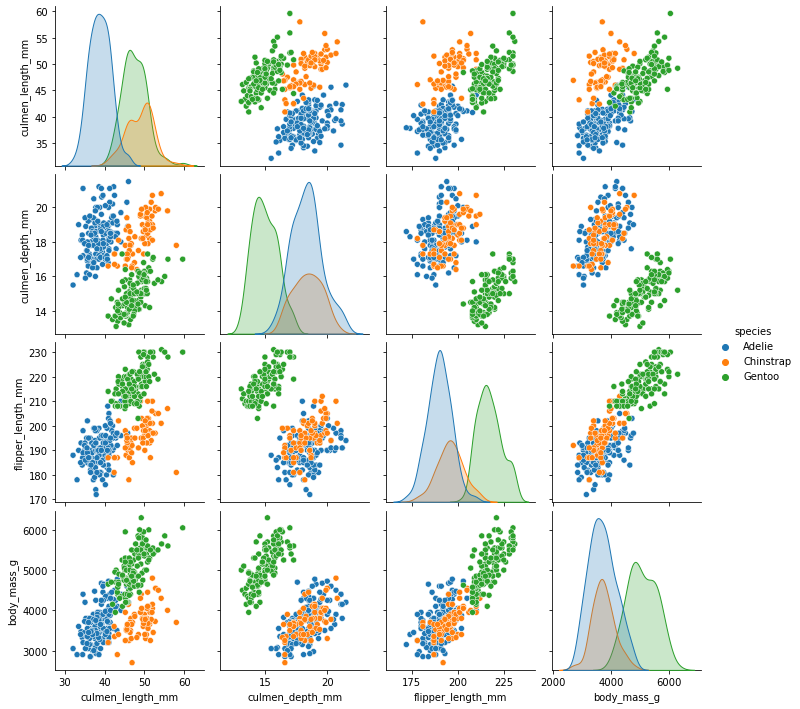

In [382]:
sns.pairplot(df.to_pandas(), hue='species')

culmen_depth,flipper_lengthは明らかに2群に分かれている。  
culmen_depth,body_mass_gも同様。  
flipper_length,body_mass_gは正の相関がある。

## ○ 外れ値のチェック

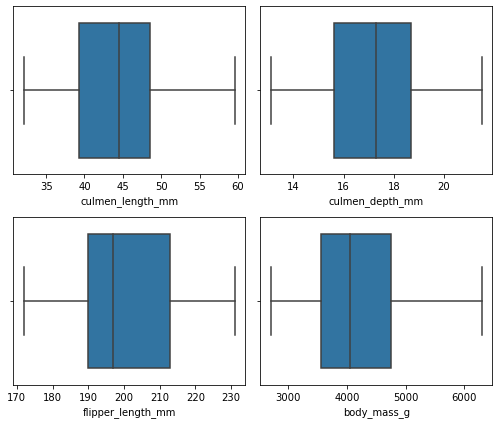

In [17]:
rows = 2
cols = 2
fig, axes = plt.subplots(rows, cols, figsize=(cols*3.5,rows*3))

# 行番号と列番号、量的変数の全組み合わせを取得する。
# これにより描画位置を指定し、各カラム同士の関係を可視化できる。
li_row_col = list(itertools.product(range(0, rows),range(0, cols)))

# 量的変数名のリストと描画位置のリストをzipでまとめる。
for feat, row_col in zip(num_feat, li_row_col):
    sns.boxplot(x=feat, data=df.to_pandas(), ax=axes[row_col])
    axes[row_col].set_xlabel(feat)

plt.tight_layout()

明らかな外れ値（ここでは四分位範囲の1.5倍）というのはなさそう。

## ○ 相関係数

In [18]:
# 量的変数の相関係数算出。nullを落としておく必要あり。pandas DFに変換しておいた方がヒートマップは見やすい。
df_corr = df[num_feat].drop_nulls().to_pandas().corr()
df_corr

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
culmen_length_mm,1.000000,-0.235053,0.656181,0.595110
culmen_depth_mm,-0.235053,1.000000,-0.583851,-0.471916
flipper_length_mm,0.656181,-0.583851,1.000000,0.871202
body_mass_g,0.595110,-0.471916,0.871202,1.000000


<AxesSubplot:>

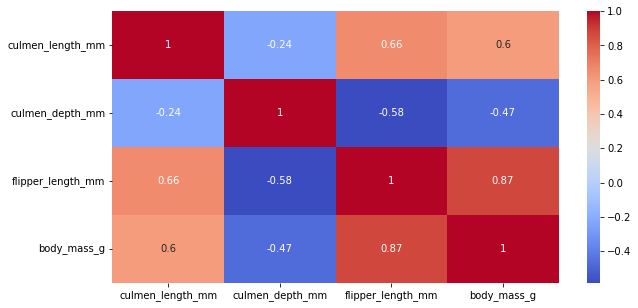

In [19]:
## heatmapを作成.数値を入れたいときはannot=Trueとする
fig, ax = plt.subplots(figsize=(10, 5)) 
sns.heatmap(df_corr, ax=ax,annot=True, cmap='coolwarm')

flipper_lengthとbody_mass_gには比較的強い相関0.87がある模様。  
翼の長さが大きければ体も大きいと思われるので、体重が重くなるのは自然と考えられる。

## Case1: 欠損値対応しない場合
LightGBMでは欠損値対応しなくても学習・予測ができるので、  
まず欠損値はそのままでやってみる。  
また、LightGBMでは標準化は必須ではないのでやらない。  
標準化する場合、CVの中に組み込む必要あり。

In [385]:
df_org = df

In [386]:
# 目的変数と特徴量に分ける。
X = df.drop('species')
y = df.get_column('species')

In [387]:
# クラス数少ないので、今回はOne-Hotエンコーディングを使用
# cat_featから'species'を削除するのは一回やればOK.このセルを複数回実行する際は注意
#cat_feat.remove('species')
X = X.to_dummies(cat_feat).to_numpy()

In [388]:
# cvインスタンスを生成。5 fold × 3で評価する。
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=0)

In [389]:
# 多クラス分類の場合、LightGBMのデータセットに入れる目的変数はラベルエンコーディングしておく必要がある。
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y.to_pandas())

参考：https://stackoverflow.com/questions/64524749/lightgbm-valueerror-series-dtypes-must-be-int-float-or-bool

In [390]:
# LightGBM用のパラメタ指定
params = {
          'objective': 'multiclass',  # 最小化させるべき損失関数
          'num_class': 3,  # マルチクラス分類の場合、クラス数を指定する必要あり。
          'metric': 'multi_logloss',  # 学習時に使用する評価指標(early_stoppingの評価指標にも同じ値が使用される)
          'random_state': 0,  # 乱数シード
          'boosting_type': 'goss',  # boosting_type
          'verbose': -1  # これを指定しないと`No further splits with positive gain, best gain: -inf`というWarningが表示される
         }

In [342]:
# LightGBMのCVを回す自作クラスを呼び出す。中身は別ファイル
scores_case1 = lightGBM_classifier_cv_func(X, y_encoded, cv, params)

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[270]	valid_0's multi_logloss: 0.00130202
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[58]	valid_0's multi_logloss: 0.0721133
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[62]	valid_0's multi_logloss: 0.0630518
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[73]	valid_0's multi_logloss: 0.0593792
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[177]	valid_0's multi_logloss: 0.00150276
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[101]	valid_0's multi_logloss: 0.0180522
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[110]	valid_0's multi_logloss: 0.00679148
Training until validation scores don't im

In [343]:
# 平均評価スコアの表示、格納
score_average_each_cases = {}
score_average_each_cases['欠損値対応なし'] = np.mean(scores_case1)
print(f"Average Logloss: {np.mean(scores_case1):.4f}")

Average Logloss: 0.0425


In [344]:
score_average_each_cases

{'欠損値対応なし': 0.0424801617520432}

欠損値を対応しない場合のloglossの平均は0.0424となった。

※lgb.cvを使うと学習結果を細かく見られないので、使わない。  
  また、cross_val_scoreもearly_stopping出来なくなるのでやらない。

## Case2: 欠損値を単に落とした場合

In [345]:
df2 = df.drop_nulls()

In [346]:
print(f'drop前のレコード数：{len(df)}, drop後のレコード数{len(df2)}')

drop前のレコード数：344, drop後のレコード数334


In [347]:
# 目的変数と特徴量に分ける。
X = df2.drop('species')
y = df2.get_column('species')

In [348]:
# クラス数少ないので、今回はOne-Hotエンコーディングを使用
X = X.to_dummies(cat_feat).to_numpy()

In [349]:
# 多クラス分類の場合、LightGBMのデータセットに入れる目的変数はラベルエンコーディングしておく必要がある。
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y.to_pandas())

In [350]:
# LightGBMのCVを回す自作クラスを呼び出す。中身は後述。
scores_case2 = lightGBM_classifier_cv_func(X, y_encoded, cv, params)

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[59]	valid_0's multi_logloss: 0.0752842
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[163]	valid_0's multi_logloss: 0.00426894
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[184]	valid_0's multi_logloss: 0.001694
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[122]	valid_0's multi_logloss: 0.00520482
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[101]	valid_0's multi_logloss: 0.024907
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[86]	valid_0's multi_logloss: 0.0625264
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[315]	valid_0's multi_logloss: 0.000155098
Training until validation scores don't im

In [351]:
# 平均評価スコアの表示、格納
score_average_each_cases['欠損値を落とす場合'] = np.mean(scores_case2)
print(f"Average Logloss: {np.mean(scores_case2):.4f}")

Average Logloss: 0.0162


In [352]:
score_average_each_cases

{'欠損値対応なし': 0.0424801617520432, '欠損値を落とす場合': 0.016215491510968447}

欠損値を落とした場合の平均loglossは0.016となり、落とさなかった場合より精度が良さそうという結果になった。  

## Case3: 欠損値を新しいカテゴリとした場合
数値カラムの欠損値は中央値で代入する。  
中央値を計算する際にテストデータを含んではいけないが、  
ここでは手元にあるデータは全て学習データのみと考えて欠損値対応する。  
なお、欠損値の代入はCVの中でやること。これは、事前に全学習データに対してやると検証データのカンニングになってしまい、  
交差検証の結果が不正に高くなってしまう恐れがあるため。

~~中央値の代入にはSimpleImputerを使ってみる。  
参考： https://zerofromlight.com/blogs/detail/70/~~  
→欠損値としてpd.NAを入れる必要があり、めんどそうだったので普通にwith_columnsでやる。


In [230]:
df.head(1)

species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
str,str,f32,f32,f32,f32,str
"""Adelie""","""Torgersen""",39.099998,18.700001,181.0,3750.0,"""MALE"""


In [231]:
df.null_count()

species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
u32,u32,u32,u32,u32,u32,u32
0,0,2,2,2,2,10


欠損値があるカラムのうち、sexはカテゴリカラムでそれ以外は数的カラムになっている。

In [353]:
# 欠損値を含むカラム名を取得
null_contain_cols = (df
 .null_count().transpose(include_header=True)
 .filter(pl.col('column_0') > 0)
 .get_column('column').to_list()
)

print(null_contain_cols)

['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g', 'sex']


In [354]:
df[null_contain_cols].null_count()

culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
u32,u32,u32,u32,u32
2,2,2,2,10


↑欠損値を含むカラム名の配列を取得。欠損値を含むカラム数が今回のように少なければよいが、  
数百とかある事例があることを想定し、書いておいた。  
単純そうで意外とめんどくさい。

In [355]:
# 複数のカラムに対して、欠損値がある行をフィルタリングするためのExprを生成する
expr = pl

for i, col in enumerate(null_contain_cols):
    if i == 0:
        expr = expr.col(col).is_null()
    else:
        # __or__は演算子'|'と同じ
        expr = expr.__or__(pl.col(col).is_null())

In [356]:
expr

In [357]:
# 欠損値がある行のindexを取得
null_index = df.with_row_count().filter(expr).get_column('row_nr')

In [358]:
null_index

row_nr
u32
3
8
9
10
11
47
246
286
324


In [359]:
# sexカラムの欠損値を'None'というカテゴリ（クラスにする）& 数値カラムの欠損値を中央値で埋める
df3 = df.with_columns(
    pl.col('sex').fill_null('None')
).with_columns(
    # sexカラム以外に対して適用するために[:-1]としている。
    [pl.col(col).fill_null(pl.col(col).median()).alias(col) for col in null_contain_cols[:-1]]
)

with_columnsは分けておく必要あり。リスト内包表記で生成したExprと単体のExprは同時に実行されない（？）模様。

In [360]:
df3.null_count()

species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,0


In [361]:
df3[null_index]

species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
str,str,f64,f64,f64,f64,str
"""Adelie""","""Torgersen""",44.450001,17.299999,197.0,4050.0,"""None"""
"""Adelie""","""Torgersen""",34.099998,18.1,193.0,3475.0,"""None"""
"""Adelie""","""Torgersen""",42.0,20.200001,190.0,4250.0,"""None"""
"""Adelie""","""Torgersen""",37.799999,17.1,186.0,3300.0,"""None"""
"""Adelie""","""Torgersen""",37.799999,17.299999,180.0,3700.0,"""None"""
"""Adelie""","""Dream""",37.5,18.9,179.0,2975.0,"""None"""
"""Gentoo""","""Biscoe""",44.5,14.3,216.0,4100.0,"""None"""
"""Gentoo""","""Biscoe""",46.200001,14.4,214.0,4650.0,"""None"""
"""Gentoo""","""Biscoe""",47.299999,13.8,216.0,4725.0,"""None"""


In [362]:
df[null_index]

species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
str,str,f32,f32,f32,f32,str
"""Adelie""","""Torgersen""",null,null,null,null,null
"""Adelie""","""Torgersen""",34.099998,18.1,193.0,3475.0,null
"""Adelie""","""Torgersen""",42.0,20.200001,190.0,4250.0,null
"""Adelie""","""Torgersen""",37.799999,17.1,186.0,3300.0,null
"""Adelie""","""Torgersen""",37.799999,17.299999,180.0,3700.0,null
"""Adelie""","""Dream""",37.5,18.9,179.0,2975.0,null
"""Gentoo""","""Biscoe""",44.5,14.3,216.0,4100.0,null
"""Gentoo""","""Biscoe""",46.200001,14.4,214.0,4650.0,null
"""Gentoo""","""Biscoe""",47.299999,13.8,216.0,4725.0,null


欠損値が埋められたことが分かる。  

In [363]:
# 目的変数と特徴量に分ける。
X = df3.drop('species')
y = df3.get_column('species')

In [364]:
# クラス数少ないので、今回はOne-Hotエンコーディングを使用
X = X.to_dummies(cat_feat).to_numpy()

In [365]:
# 多クラス分類の場合、LightGBMのデータセットに入れる目的変数はラベルエンコーディングしておく必要がある。
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y.to_pandas())

In [366]:
# cvインスタンスを生成。5 fold × 3で評価する。
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=0)

In [367]:
# LightGBMのCVを回す自作クラスを呼び出す。中身は別ファイル
scores_case3 = lightGBM_classifier_cv_func(X, y_encoded, cv, params)

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[291]	valid_0's multi_logloss: 0.00102289
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[60]	valid_0's multi_logloss: 0.0487807
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[94]	valid_0's multi_logloss: 0.0285103
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[74]	valid_0's multi_logloss: 0.0570705
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[126]	valid_0's multi_logloss: 0.00362289
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[98]	valid_0's multi_logloss: 0.021658
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[190]	valid_0's multi_logloss: 0.00135898
Training until validation scores don't impr

In [368]:
# 平均評価スコアの表示、格納
score_average_each_cases['欠損値を新しいカテゴリとする・中央値で補完'] = np.mean(scores_case3)
print(f"Average Logloss: {np.mean(scores_case3):.4f}")

Average Logloss: 0.0318


In [369]:
score_average_each_cases

{'欠損値対応なし': 0.0424801617520432,
 '欠損値を落とす場合': 0.016215491510968447,
 '欠損値を新しいカテゴリとする・中央値で補完': 0.03181527210999389}

Case3ではまずまずの結果となった。

## Case4: 欠損値をkNNで予測した場合
数値カラムの欠損値をkNNで予測する。  
カテゴリカラムは最頻値で代入する。
最頻値を計算する際にテストデータを含んではいけないが、  
ここでは手元にあるデータは全て学習データのみと考えて欠損値対応する。  


In [269]:
df.null_count()

species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
u32,u32,u32,u32,u32,u32,u32
0,0,2,2,2,2,10


In [291]:
# MALEが最頻値
df['sex'].value_counts()

sex,counts
str,u32
null,10
"""others""",1
"""FEMALE""",165
"""MALE""",168


In [370]:
# sexの欠損値を最頻値で埋める
df4 = df.with_columns(
    pl.col('sex').fill_null(pl.col('sex').mode()).alias('sex')
)

In [371]:
df4[null_index]

species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
str,str,f32,f32,f32,f32,str
"""Adelie""","""Torgersen""",null,null,null,null,"""MALE"""
"""Adelie""","""Torgersen""",34.099998,18.1,193.0,3475.0,"""MALE"""
"""Adelie""","""Torgersen""",42.0,20.200001,190.0,4250.0,"""MALE"""
"""Adelie""","""Torgersen""",37.799999,17.1,186.0,3300.0,"""MALE"""
"""Adelie""","""Torgersen""",37.799999,17.299999,180.0,3700.0,"""MALE"""
"""Adelie""","""Dream""",37.5,18.9,179.0,2975.0,"""MALE"""
"""Gentoo""","""Biscoe""",44.5,14.3,216.0,4100.0,"""MALE"""
"""Gentoo""","""Biscoe""",46.200001,14.4,214.0,4650.0,"""MALE"""
"""Gentoo""","""Biscoe""",47.299999,13.8,216.0,4725.0,"""MALE"""


In [372]:
# ダミー変数に変換するときはpandasの方が便利かも
df4 = pd.get_dummies(df4.to_pandas(), drop_first=True)

In [373]:
num_feat

['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g']

kNNの目的変数となるカラムは全て量的変数であり、特徴量はカテゴリ変数なので、  
標準化の必要はない。

In [374]:
# kNNImputerで欠損値を予測
imputer = KNNImputer(n_neighbors=3)
imputer.set_output(transform='pandas')
df4_imputed = imputer.fit_transform(df4)

In [375]:
pl.from_pandas(df4_imputed)[null_index]

culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,species_Chinstrap,species_Gentoo,island_Dream,island_Torgersen,sex_MALE,sex_others
f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
37.466667,18.800001,189.666672,3966.666748,0.0,0.0,0.0,1.0,1.0,0.0
34.099998,18.1,193.0,3475.0,0.0,0.0,0.0,1.0,1.0,0.0
42.0,20.200001,190.0,4250.0,0.0,0.0,0.0,1.0,1.0,0.0
37.799999,17.1,186.0,3300.0,0.0,0.0,0.0,1.0,1.0,0.0
37.799999,17.299999,180.0,3700.0,0.0,0.0,0.0,1.0,1.0,0.0
37.5,18.9,179.0,2975.0,0.0,0.0,1.0,0.0,1.0,0.0
44.5,14.3,216.0,4100.0,0.0,1.0,0.0,0.0,1.0,0.0
46.200001,14.4,214.0,4650.0,0.0,1.0,0.0,0.0,1.0,0.0
47.299999,13.8,216.0,4725.0,0.0,1.0,0.0,0.0,1.0,0.0


In [376]:
pl.from_pandas(df4)[null_index]

culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,species_Chinstrap,species_Gentoo,island_Dream,island_Torgersen,sex_MALE,sex_others
f32,f32,f32,f32,u8,u8,u8,u8,u8,u8
null,null,null,null,0,0,0,1,1,0
34.099998,18.1,193.0,3475.0,0,0,0,1,1,0
42.0,20.200001,190.0,4250.0,0,0,0,1,1,0
37.799999,17.1,186.0,3300.0,0,0,0,1,1,0
37.799999,17.299999,180.0,3700.0,0,0,0,1,1,0
37.5,18.9,179.0,2975.0,0,0,1,0,1,0
44.5,14.3,216.0,4100.0,0,1,0,0,1,0
46.200001,14.4,214.0,4650.0,0,1,0,0,1,0
47.299999,13.8,216.0,4725.0,0,1,0,0,1,0


量的変数のカラムの欠損値が埋められたことが分かる

In [377]:
# 本来の目的変数のカラムを特徴量から削除
X = np.array( df4_imputed.loc[:, ~df4_imputed.columns.str.contains('species')].copy() )
y = df['species']

In [378]:
# 多クラス分類の場合、LightGBMのデータセットに入れる目的変数はラベルエンコーディングしておく必要がある。
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y.to_pandas())

In [379]:
# LightGBMのCVを回す自作クラスを呼び出す。中身は別ファイル
scores_case4 = lightGBM_classifier_cv_func(X, y_encoded, cv, params)

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[340]	valid_0's multi_logloss: 0.00110683
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[37]	valid_0's multi_logloss: 0.123082
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[181]	valid_0's multi_logloss: 0.00673217
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[67]	valid_0's multi_logloss: 0.0841613
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[176]	valid_0's multi_logloss: 0.00180532
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[57]	valid_0's multi_logloss: 0.0503266
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[203]	valid_0's multi_logloss: 0.00351881
Training until validation scores don't im

In [380]:
# 平均評価スコアの表示、格納
score_average_each_cases['欠損値をkNNで予測した場合'] = np.mean(scores_case4)
print(f"Average Logloss: {np.mean(scores_case4):.4f}")

Average Logloss: 0.0487


In [381]:
score_average_each_cases

{'欠損値対応なし': 0.0424801617520432,
 '欠損値を落とす場合': 0.016215491510968447,
 '欠損値を新しいカテゴリとする・中央値で補完': 0.03181527210999389,
 '欠損値をkNNで予測した場合': 0.04870434039347336}

欠損値をkNNで予測した場合が最も精度が良くなさそう。  
結局ケースバイケースでどの対応をとるべきかこのように検証して考えることが重要なのだと思われる。  
island以外全てnullのレコードがあったが、ここから目的変数を正確に予測するのは難しいので、  
Case2のように落としてしまうのも今回の場合は一つの手。  

In [ ]:
df[null_index[0,-1]]

species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
str,str,f32,f32,f32,f32,str
"""Adelie""","""Torgersen""",null,null,null,null,null
"""Gentoo""","""Biscoe""",null,null,null,null,null
